In [1]:
import numpy as np 
import pandas as pd 

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.utils as ku
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import seaborn as sns

labelencoder = LabelEncoder()


In [3]:
#!pip install keras

In [4]:
#!pip install tensorflow

In [5]:
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

print('Train shape:',data_train.shape)
print('Test shape:',data_test.shape)

Train shape: (19579, 3)
Test shape: (8392, 2)


In [6]:
data_train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [7]:
StopWords = set(stopwords.words('english'))

def text_preprocess(text):
    trans = str.maketrans('','',string.punctuation)
    text = text.translate(trans)
    text = ' '.join([word.lower() for word in text.split() if word.lower() not in StopWords])
    return text

data_train['text'] = data_train['text'].apply(text_preprocess)
data_test['text'] = data_test['text'].apply(text_preprocess)
data_train.head()

,id,text,author
0,id26305,process however afforded means ascertaining di...,EAP
1,id17569,never occurred fumbling might mere mistake,HPL
2,id11008,left hand gold snuff box capered hill cutting ...,EAP
3,id27763,lovely spring looked windsor terrace sixteen f...,MWS
4,id12958,finding nothing else even gold superintendent ...,HPL


<AxesSubplot:>

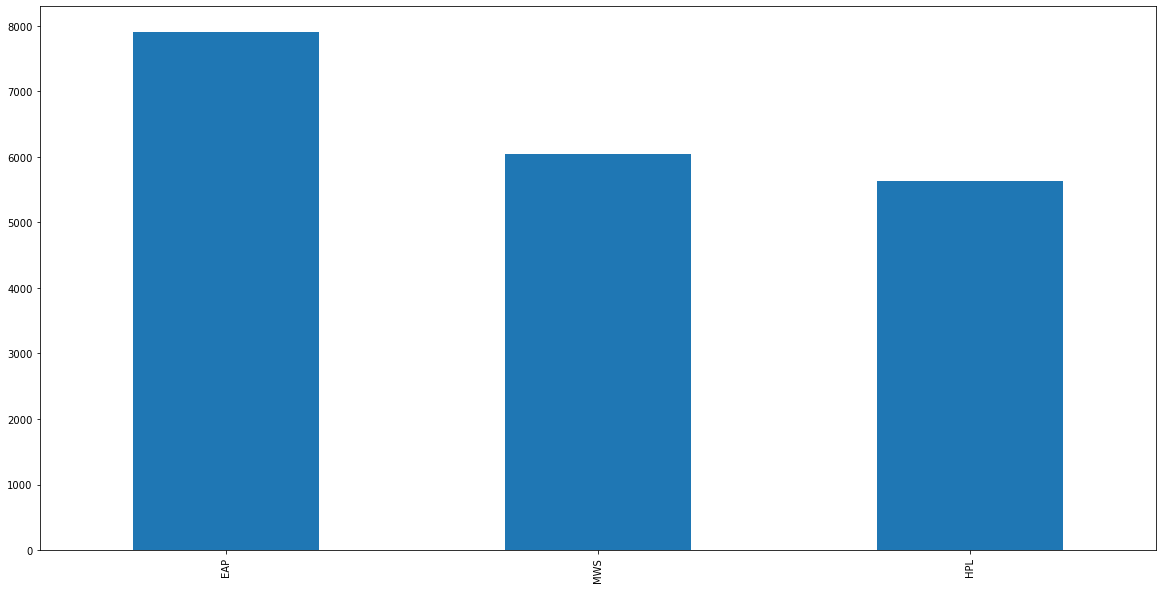

In [8]:
plt.figure(figsize = (20,10))
data_train['author'].value_counts().plot(kind = 'bar')

## Violin-Plot 

In [9]:
data_train['num_words'] = data_train['text'].apply(lambda x : len(str(x).split()))
data_test['num_words'] = data_test['text'].apply(lambda x : len(str(x).split()))

<AxesSubplot:xlabel='author', ylabel='num_words'>

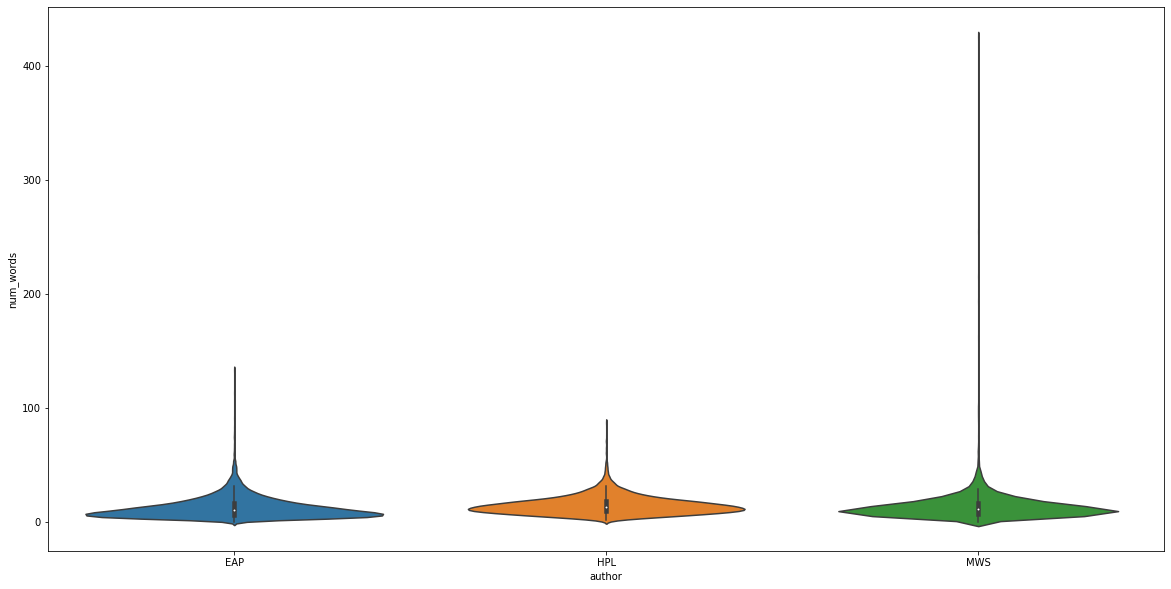

In [10]:
plt.figure(figsize = (20,10))
sns.violinplot(x = 'author' , y = 'num_words' , data = data_train)

## WordCloud

In [24]:
#import sys
#print(sys.executable)

G:\MEDIA\SOFTWARE\Conda\python.exe


In [ ]:
#conda install -c https://conda.anaconda.org/conda-forge wordcloud

In [30]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
df = pd.read_csv("train.csv")

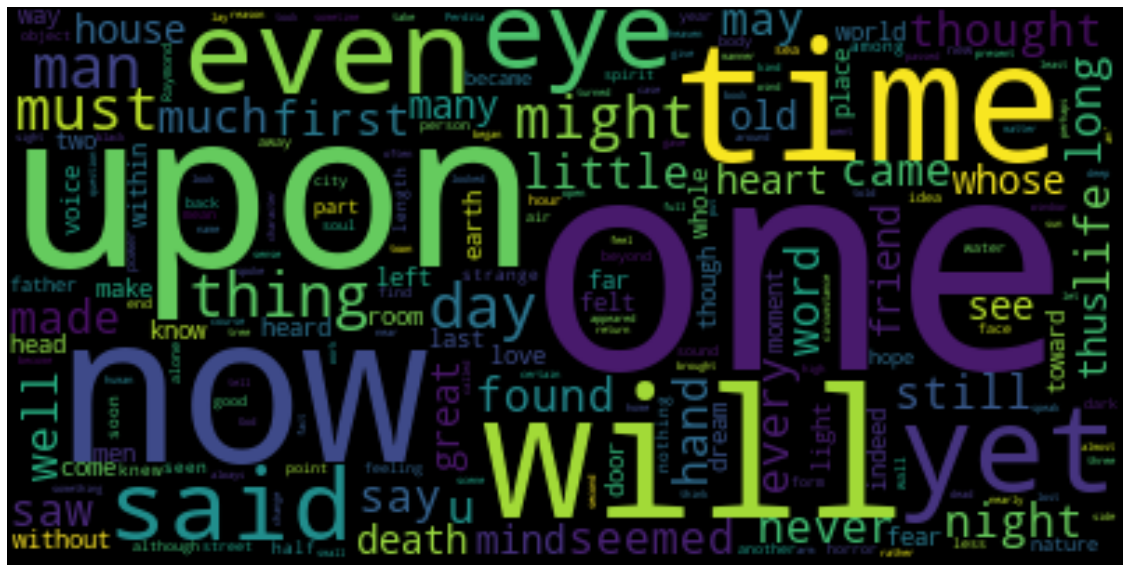

In [32]:
text = df["text"].str.cat()
plt.figure(figsize = (20, 20))
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Tokenization and lemmatization

In [33]:
label_encoder = LabelEncoder()
X_train = data_train['text']
X_train = X_train.tolist()
X_test = data_test['text']
X_test = X_test.tolist()
y_train = data_train['author']
y_train = label_encoder.fit_transform(y_train)
y_train_cat = ku.to_categorical(y_train, num_classes=3)
val_id = data_test['id']

lemmatizer = WordNetLemmatizer()
X_train_lemm = []
for text in X_train:
    lem_text = ''
    for word in text.split():
        lem_word = lemmatizer.lemmatize(word, pos='v')
        lem_word = lemmatizer.lemmatize(lem_word)
        lem_text = lem_text + ' ' + lem_word
    X_train_lemm.append(lem_text)

X_test_lemm = []
for text in X_test:
    lem_text = ''
    for word in text.split():
        lem_word = lemmatizer.lemmatize(word, pos='v')
        lem_word = lemmatizer.lemmatize(lem_word)
        lem_text = lem_text + ' ' + lem_word
    X_test_lemm.append(lem_text)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_lemm)
vocab_size = len(tokenizer.word_index)
max_len = 150
train_seq = tokenizer.texts_to_sequences(X_train_lemm)
train_pad = pad_sequences(train_seq, maxlen=max_len)
test_seq = tokenizer.texts_to_sequences(X_test_lemm)
test_pad = pad_sequences(test_seq, maxlen=max_len)

label2idx = {
    'EAP': 0,
    'HPL': 1,
    'MWS': 2
}

In [34]:
#import nltk
#nltk.download('wordnet')

In [35]:
tfidf = TfidfVectorizer(ngram_range=(1,3), min_df=5, max_df=0.5)
X_train_tfidf = tfidf.fit_transform(X_train_lemm)
X_test_tfidf = tfidf.transform(X_test_lemm)

In [36]:
clf = LogisticRegression(max_iter=1000).fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
print(y_pred)
output_prob = clf.predict_proba(X_test_tfidf)
output_prob[:,0]

[2 0 1 ... 0 2 1]


array([0.18964984, 0.51297798, 0.37707126, ..., 0.64168639, 0.26446436,
       0.45248082])

## Long short-term memory, artificial recurrent neural network architecture, deep learning

In [38]:
#from tensorflow import keras

In [40]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size+1, 300, input_length=max_len),
    keras.layers.SpatialDropout1D(0.5),
    keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    keras.layers.Bidirectional(keras.layers.LSTM(32, dropout=0.3, recurrent_dropout=0.3)),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(train_pad, y_train_cat, epochs=3, batch_size=128)

Epoch 1/3
153/153 [==============================] - 306s 2s/step - loss: 0.6441 - accuracy: 0.7272
Epoch 2/3
153/153 [==============================] - 286s 2s/step - loss: 0.2962 - accuracy: 0.8897
Epoch 3/3
153/153 [==============================] - 293s 2s/step - loss: 0.1771 - accuracy: 0.9334


In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 300)          5430300   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 150, 300)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_4 (Bidirectio  (None, 150, 128)         186880    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 300)               19500     
                                                      